In [1]:

import os
import random
import skimage.io
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v1 as tf

# Allow image embeding in notebook
%matplotlib inline

In [2]:

def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.io.imread(f))
            labels.append(int(d))
    return images, labels


# Load training and testing datasets.
ROOT_PATH = "traffic"
train_data_dir = os.path.join(ROOT_PATH, "datasets/BelgiumTS/Training/Training")
test_data_dir = os.path.join(ROOT_PATH, "datasets/BelgiumTS/Testing/Testing")

images, labels = load_data(train_data_dir)


In [3]:
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

Unique Labels: 62
Total Images: 4575


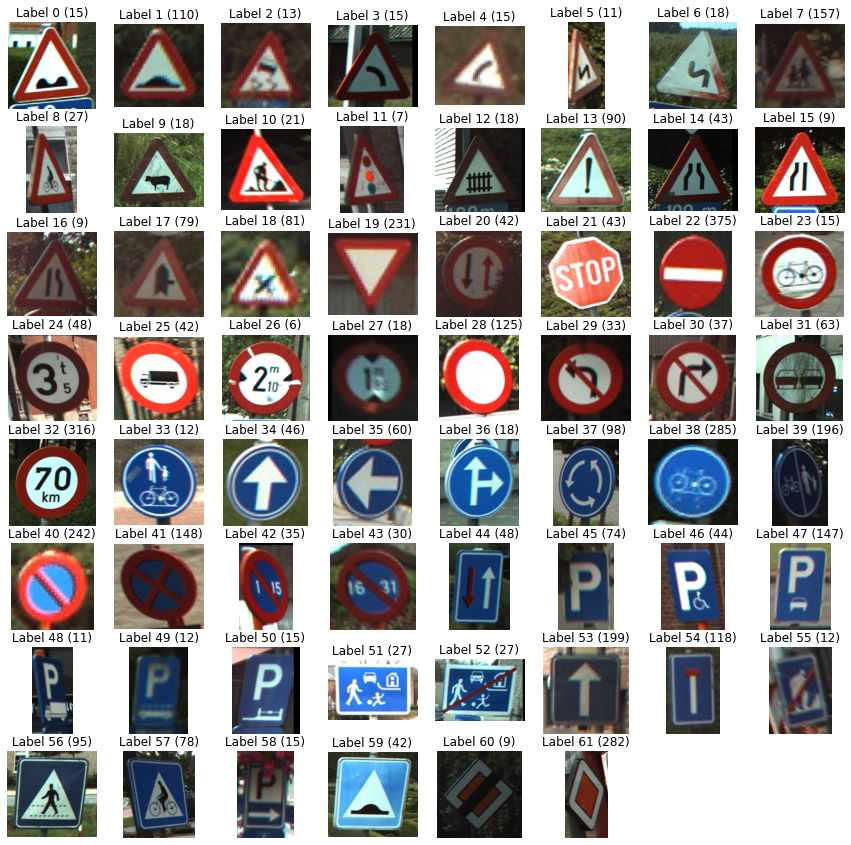

In [4]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

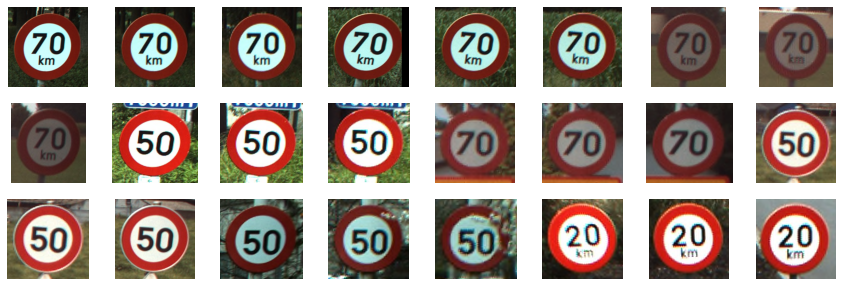

In [5]:
def display_label_images(images, label):
    """Display images of a specific label."""
    limit = 24  # show a max of 24 images
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

display_label_images(images, 32)

In [6]:
for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))
    

shape: (141, 142, 3), min: 0, max: 255
shape: (120, 123, 3), min: 0, max: 255
shape: (105, 107, 3), min: 0, max: 255
shape: (94, 105, 3), min: 7, max: 255
shape: (128, 139, 3), min: 0, max: 255


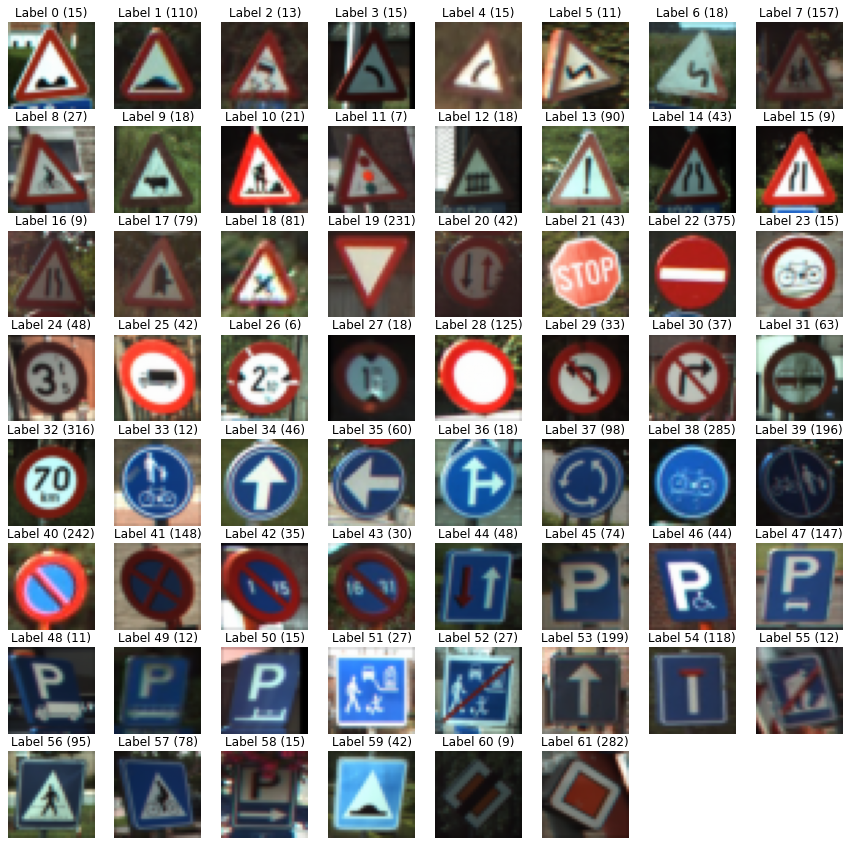

In [7]:
# Resize images
images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                for image in images]
display_images_and_labels(images32, labels)

In [8]:
for image in images32[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (32, 32, 3), min: 0.03529411764705882, max: 0.996078431372549
shape: (32, 32, 3), min: 0.033953737745098134, max: 0.996078431372549
shape: (32, 32, 3), min: 0.03694182751225489, max: 0.996078431372549
shape: (32, 32, 3), min: 0.06296913296568629, max: 0.9191425398284313
shape: (32, 32, 3), min: 0.06035539215686279, max: 0.9028492647058823


In [9]:
labels_a = np.array(labels)
images_a = np.array(images32)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)

labels:  (4575,) 
images:  (4575, 32, 32, 3)


In [10]:
# Create a graph to hold the model.
graph = tf.Graph()

# Create model in the graph.
with graph.as_default():

    # Placeholders for inputs and labels.
    images_ph = tf.compat.v1.placeholder(tf.float32, [None, 32, 32, 3])
    labels_ph = tf.compat.v1.placeholder(tf.int32, [None])

    # Flatten input from: [None, height, width, channels]
    # To: [None, height * width * channels] == [None, 3072]
    images_flat = tf.contrib.layers.flatten(images_ph)

    # Fully connected layer. 
    # Generates logits of size [None, 62]
    logits = tf.contrib.layers.fully_connected(images_flat, 62, tf.nn.relu)

    # Convert logits to label indexes (int).
    # Shape [None], which is a 1D vector of length == batch_size.
    predicted_labels = tf.argmax(logits, 1)

    # Define the loss function. 
    # Cross-entropy is a good choice for classification.
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels_ph))

    # Create training op.
    train = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

    # And, finally, an initialization op to execute before training.
    init = tf.global_variables_initializer()

print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", predicted_labels)

AttributeError: module 'tensorflow.compat.v1' has no attribute 'contrib'

In [ ]:
 Create a session to run the graph we created.
session = tf.Session(graph=graph)

# First step is always to initialize all variables. 
# We don't care about the return value, though. It's None.
_ = session.run([init])

In [ ]:
for i in range(201):
    _, loss_value = session.run([train, loss], 
                                feed_dict={images_ph: images_a, labels_ph: labels_a})
    if i % 10 == 0:
        print("Loss: ", loss_value)

In [ ]:
# Pick 10 random images
sample_indexes = random.sample(range(len(images32)), 10)
sample_images = [images32[i] for i in sample_indexes]
sample_labels = [labels[i] for i in sample_indexes]

# Run the "predicted_labels" op.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: sample_images})[0]
print(sample_labels)
print(predicted)

In [ ]:
# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i])